<a href="https://colab.research.google.com/github/vikasmeena23/DMS672-Assignments-/blob/main/DecisionTrees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is an example of how we will implement decision tree when attributes are ordinal. We will assign numerical lables to ordinal attributes based on their order .

In [ ]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Sample data with ordinal features
data = pd.DataFrame({
    'EducationLevel': ['Bachelor', 'High School', 'Master', 'PhD', 'Bachelor', 'Master', 'PhD', 'High School'],
    'StudyHours': [20, 10, 30, 50, 15, 35, 40, 5],
    'Attendance': ['High', 'Low', 'Medium', 'High', 'Medium', 'High', 'High', 'Low'],
    'Pass': [1, 0, 1, 1, 1, 1, 1, 0]
})

# 1. Encode ordinal features
edu_mapping = {'High School': 0, 'Bachelor': 1, 'Master': 2, 'PhD': 3}
att_mapping = {'Low': 0, 'Medium': 1, 'High': 2}

data['EducationLevel'] = data['EducationLevel'].map(edu_mapping)
data['Attendance'] = data['Attendance'].map(att_mapping)

# 2. Feature-target split
X = data[['EducationLevel', 'StudyHours', 'Attendance']]
y = data['Pass']

# 3. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 4. Decision Tree using Entropy
clf = DecisionTreeClassifier(criterion='entropy', random_state=0)
clf.fit(X_train, y_train)

# 5. Prediction and accuracy
y_pred = clf.predict(X_test)
print("Accuracy (Entropy-based):", accuracy_score(y_test, y_pred))




Accuracy (Entropy-based): 1.0


## Imorting and creating the df and cleaning it.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
df = pd.read_csv('/content/Telco-Customer-Churn.csv')

In [ ]:
# Drop useless column
df = df.drop('customerID', axis=1)

# Clean TotalCharges (convert to numeric, coerce errors)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')


# Drop rows where TotalCharges is NaN
df = df.dropna(subset=['TotalCharges'])

# Optionally reset index
df = df.reset_index(drop=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7032 non-null   object 
 1   SeniorCitizen     7032 non-null   int64  
 2   Partner           7032 non-null   object 
 3   Dependents        7032 non-null   object 
 4   tenure            7032 non-null   int64  
 5   PhoneService      7032 non-null   object 
 6   MultipleLines     7032 non-null   object 
 7   InternetService   7032 non-null   object 
 8   OnlineSecurity    7032 non-null   object 
 9   OnlineBackup      7032 non-null   object 
 10  DeviceProtection  7032 non-null   object 
 11  TechSupport       7032 non-null   object 
 12  StreamingTV       7032 non-null   object 
 13  StreamingMovies   7032 non-null   object 
 14  Contract          7032 non-null   object 
 15  PaperlessBilling  7032 non-null   object 
 16  PaymentMethod     7032 non-null   object 


In [ ]:
df.count()


,0
gender,7032
SeniorCitizen,7032
Partner,7032
Dependents,7032
tenure,7032
PhoneService,7032
MultipleLines,7032
InternetService,7032
OnlineSecurity,7032
OnlineBackup,7032


## Preprocessing

In [ ]:
X = df.drop('Churn', axis=1)
y = df['Churn']

In [ ]:
from sklearn.preprocessing import LabelEncoder

for col in X.select_dtypes(include=['object', 'category']).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])


In [ ]:
y = LabelEncoder().fit_transform(y)


## Splitting into test and train sets


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


## Applying Decision tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(
    criterion='entropy',         # or 'entropy'
    max_depth=None,           # No max depth (fully grown)
    min_samples_split=2,
    min_samples_leaf=1
)

clf.fit(X_train, y_train)


DecisionTreeClassifier(criterion='entropy')

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.7391613361762616


We got an accuracy of 0.745 on the test set.

In [ ]:

# Get depth of the tree
print("Depth of the tree:", clf.get_depth())

# Get number of leaf nodes
print("Number of leaf nodes:", clf.get_n_leaves())

Depth of the tree: 34
Number of leaf nodes: 1087


## Visualizing the tree

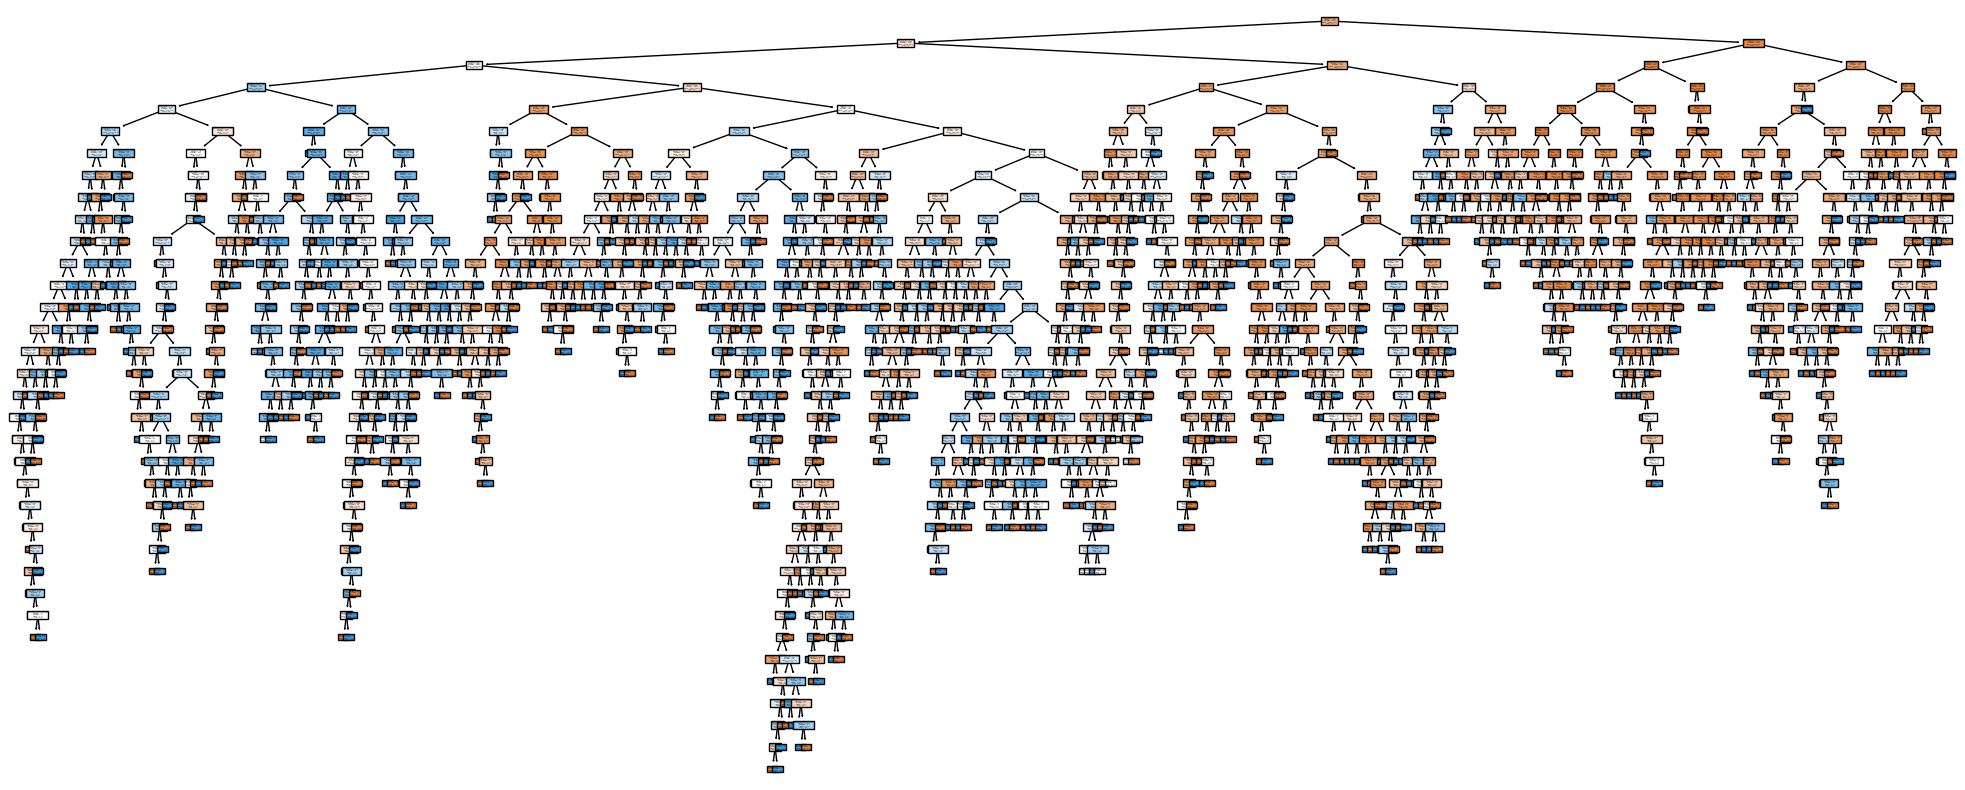

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(25, 10))
plot_tree(clf, filled=True, feature_names=X.columns, class_names=['No', 'Yes'])
plt.show()


## Creating custom tree for pre-pruning

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
from collections import Counter

class PrePrunedDecisionTree:
    def __init__(self, min_samples=10, significance_level=0.05, min_gain=0.01):
        """
        min_samples: Minimum number of samples required to split
        significance_level: Alpha value for chi-squared test (e.g., 0.05)
        min_gain: Minimum information gain required to split (e.g., 0.01)
        """
        self.min_samples = min_samples
        self.alpha = significance_level
        self.min_gain = min_gain
        self.tree = None

    def entropy(self, y):
        counts = Counter(y)
        total = len(y)
        return -sum((count/total) * np.log2(count/total) for count in counts.values())

    def info_gain(self, y, splits):
        H = self.entropy(y)
        weighted_entropy = sum(len(split)/len(y) * self.entropy(split) for split in splits)
        return H - weighted_entropy

    def best_split(self, X, y):
        best_attr, best_gain, best_splits = None, 0, None

        for attr in X.columns:
            if X[attr].dtype == 'object' or X[attr].nunique() <= 10:
                # Categorical: Chi-squared + info gain
                contingency = pd.crosstab(X[attr], y)
                chi2, p, _, _ = chi2_contingency(contingency)

                if p >= self.alpha:
                    continue  # skip this attribute if not significant

                groups = [y[X[attr] == val] for val in X[attr].unique()]
                gain = self.info_gain(y, groups)

                if gain > best_gain and gain >= self.min_gain:
                    best_attr, best_gain, best_splits = attr, gain, groups

            else:
                # Continuous: try all split thresholds
                thresholds = X[attr].sort_values().unique()[1:]
                for t in thresholds:
                    left = y[X[attr] <= t]
                    right = y[X[attr] > t]
                    if len(left) == 0 or len(right) == 0:
                        continue
                    gain = self.info_gain(y, [left, right])

                    if gain > best_gain and gain >= self.min_gain:
                        best_attr, best_gain, best_splits = (attr, t), gain, [left, right]

        return best_attr

    def fit_tree(self, X, y):
        # Rule 3: Don't split if too few samples
        if len(y) < self.min_samples or len(set(y)) == 1:
            return Counter(y).most_common(1)[0][0]

        split_attr = self.best_split(X, y)

        # If no valid split found, make it a leaf
        if split_attr is None:
            return Counter(y).most_common(1)[0][0]

        node = {"split": split_attr, "branches": {}}

        if isinstance(split_attr, tuple):  # continuous
            attr, thresh = split_attr
            left_idx = X[attr] <= thresh
            right_idx = X[attr] > thresh
            node['branches']['<='] = self.fit_tree(X[left_idx], y[left_idx])
            node['branches']['>'] = self.fit_tree(X[right_idx], y[right_idx])
        else:  # categorical
            for val in X[split_attr].unique():
                idx = X[split_attr] == val
                node['branches'][val] = self.fit_tree(X[idx], y[idx])

        return node

    def fit(self, X, y):
        self.tree = self.fit_tree(X, y)


    def predict_one(self, x, node):
        if not isinstance(node, dict):
            return node
        split = node["split"]
        if isinstance(split, tuple):  # continuous
            attr, thresh = split
            branch = "<=" if x[attr] <= thresh else ">"
        else:
            branch = x[split]
        if branch not in node["branches"]:
            return None
        return self.predict_one(x, node["branches"][branch])

    def predict(self, X):
        return [self.predict_one(x, self.tree) for _, x in X.iterrows()]


## Using the custom tree

In [ ]:
tree = PrePrunedDecisionTree(
    min_samples=20,          # Rule 3
    significance_level=0.05, # Rule 2
    min_gain=0.02           # Rule 1
)

tree.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = tree.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))


Test Accuracy: 0.0


We saw an improvement in accuracy from 0.745 to 0.767.

In [ ]:
def count_leaves_and_depth(node, depth=0):
    if not isinstance(node, dict):
        return 1, depth  # 1 leaf, depth of this path

    max_depth = depth
    leaf_count = 0

    for branch in node["branches"].values():
        leaves, branch_depth = count_leaves_and_depth(branch, depth + 1)
        leaf_count += leaves
        max_depth = max(max_depth, branch_depth)

    return leaf_count, max_depth


In [ ]:
num_leaves, max_depth = count_leaves_and_depth(tree.tree)

print("Number of leaf nodes:", num_leaves)
print("Maximum depth of tree:", max_depth)


Number of leaf nodes: 116
Maximum depth of tree: 18


We saw a significant drop in tree depth fromm 32 to 16 and in number of leaf nodes from 1090 to 116.

## Post pruning

In [ ]:
def prune_tree(node, X, y, alpha=0.01):
    if not isinstance(node, dict):
        return node  # already a leaf

    split = node["split"]
    branches = node["branches"]

    # Recurse on each child first
    for key in list(branches.keys()):
        branch_idx = get_branch_indices(X, split, key)
        branches[key] = prune_tree(branches[key], X[branch_idx], y[branch_idx], alpha)

    # Evaluate subtree error
    preds = [predict_one_from_subtree(node, row) for _, row in X.iterrows()]
    subtree_error = sum(pred != true for pred, true in zip(preds, y))

    # Evaluate leaf replacement
    majority = Counter(y).most_common(1)[0][0]
    leaf_error = sum(majority != val for val in y)

    # If pruning improves cost, convert to leaf
    if leaf_error + alpha < subtree_error:
        return majority
    else:
        return node


In [ ]:
def get_branch_indices(X, split, branch_key):
    if isinstance(split, tuple):  # continuous
        attr, threshold = split
        if branch_key == '<=':
            return X[attr] <= threshold
        else:
            return X[attr] > threshold
    else:  # categorical
        return X[split] == branch_key


In [ ]:
def predict_one_from_subtree(node, x):
    if not isinstance(node, dict):
        return node
    split = node["split"]
    if isinstance(split, tuple):
        attr, thresh = split
        branch = '<=' if x[attr] <= thresh else '>'
    else:
        branch = x[split]
    return predict_one_from_subtree(node["branches"].get(branch, list(node["branches"].values())[0]), x)


In [ ]:
pptree = PrePrunedDecisionTree(min_samples=2, min_gain=0.0, significance_level=1.0)  # Fully grown
pptree.fit(X_train, y_train)

In [ ]:
# 2. Post-prune using your custom cost-complexity pruning function
pptree.tree = prune_tree(pptree.tree, X_train, y_train, alpha=0.01)

# 3. Predict on test set
y_pred = pptree.predict(X_test)

# 4. Ensure both y_pred and y_test are in correct label format (strings)
y_pred = np.array(y_pred).astype(str)
y_test = np.array(y_test).astype(str)

# 5. Evaluate accuracy
from sklearn.metrics import accuracy_score
print("Post-Pruned Accuracy:", accuracy_score(y_test, y_pred))

Post-Pruned Accuracy: 0.7405828002842928


After post pruning we get an accuracy of 0.74 as compared to 0.767 using pre pruning and 0.74 using fully grown tree.